<a href="https://colab.research.google.com/github/shreya2509/Denoising-Autoencoder/blob/master/Denoise_ScheDA_NoiseHigh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
import os
import pickle
import numpy as np

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_noise = np.copy(x_train)
x_test_noise = np.copy(x_test)
x_train_noise=x_train_noise.astype('float32')
x_test_noise=x_test_noise.astype('float32')
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

In [4]:
def normalize(img):
  img =img/255
  return img

In [5]:
# Function to add masking noise

def addnoise(img,p):
  img=normalize(img)
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      e=np.random.random()
      if (e<p):
        img[i,j,:]=0
  return img



In [6]:
for i in range(0,len(x_train_noise)):
  x_train_noise[i]=addnoise(x_train_noise[i],0.7)


In [7]:
for i in range(0,len(x_test_noise)):
  x_test_noise[i]=addnoise(x_test_noise[i],0.7)

In [8]:
for i in range(0,len(x_train)):
  x_train[i]=normalize(x_train[i])

In [9]:
for i in range(0,len(x_test)):
  x_test[i]=normalize(x_test[i])

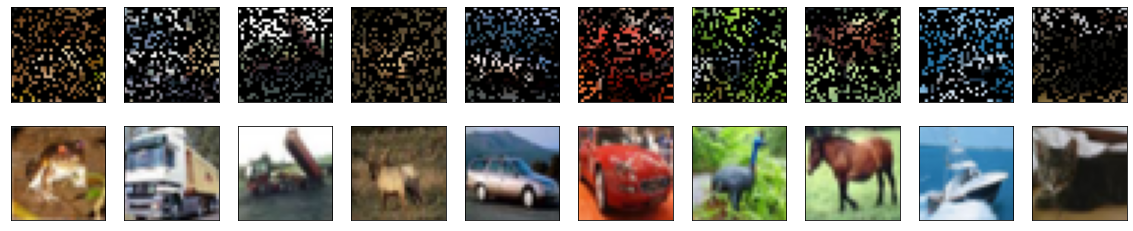

In [10]:
# Function to visualize the noise added

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 4))
for i in range(0,10):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(x_train_noise[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
for i in range(0,10):
  ax=plt.subplot(2,10,i+11)
  plt.imshow(x_train[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


Convolutional Autoencoder

In [11]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Flatten()(x)
x = Dense(3072)(x)
x = BatchNormalization()(x)
encoded = Activation('sigmoid')(x)

In [12]:
x = Dense(3072)(encoded)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Reshape((32,32,3))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [13]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
checkpoint_path = "checkpoints"
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = checkpoint_path + 'AutoEncoder_Cifar10_delineBlack_CAE_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [14]:
cp_callback =ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Training the Autoencoder

In [15]:
history = model.fit(x_train_noise, x_train,
                    batch_size=50,
                    epochs=15,
                    verbose=1,
                    validation_data=(x_test_noise, x_test),
                    callbacks=[cp_cb,es_cb],
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 103s 2ms/step - loss: 0.0129 - val_loss: 0.0080

Epoch 00001: val_loss improved from inf to 0.00797, saving model to checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.01-0.01-0.01.hdf5
Epoch 2/15
50000/50000 [==============================] - 96s 2ms/step - loss: 0.0082 - val_loss: 0.0070

Epoch 00002: val_loss improved from 0.00797 to 0.00700, saving model to checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.02-0.01-0.01.hdf5
Epoch 3/15
50000/50000 [==============================] - 96s 2ms/step - loss: 0.0072 - val_loss: 0.0067

Epoch 00003: val_loss improved from 0.00700 to 0.00674, saving model to checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.03-0.01-0.01.hdf5
Epoch 4/15
50000/50000 [==============================] - 96s 2ms/step - loss: 0.0066 - val_loss: 0.0064

Epoch 00004: val_loss improved from 0.00674 to 0.00639, saving model to checkpointsAutoEncoder

In [27]:
c10test = model.predict(x_test_noise)

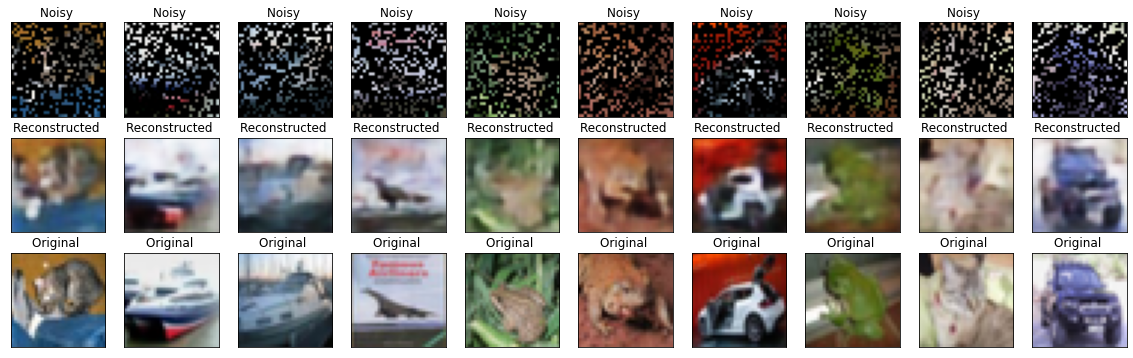

In [29]:
plt.figure(figsize=(20, 6))
for i in range(0,10):
  plt.title('Noisy ')
  ax=plt.subplot(3,10,i+1)
  plt.imshow(x_test_noise[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
#for i in range(0,10):
#  ax=plt.subplot(2,10,i+11)
#  plt.imshow(x_train[i])
#  ax.get_xaxis().set_visible(False)
#  ax.get_yaxis().set_visible(False)
for i in range(0,10):
  ax=plt.subplot(3,10,i+11)
  plt.imshow(c10test[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Reconstructed ')

for i in range(0,10):
  ax=plt.subplot(3,10,i+21)
  plt.imshow(x_test[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original ')

Visulizing the features learnt

In [15]:
model.load_weights("checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.09-0.00-0.01.hdf5")

In [22]:
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[9].output])
layer_output = get_3rd_layer_output([x_test_noise])[0]

In [23]:
print(layer_output.shape)

(10000, 32, 32, 32)


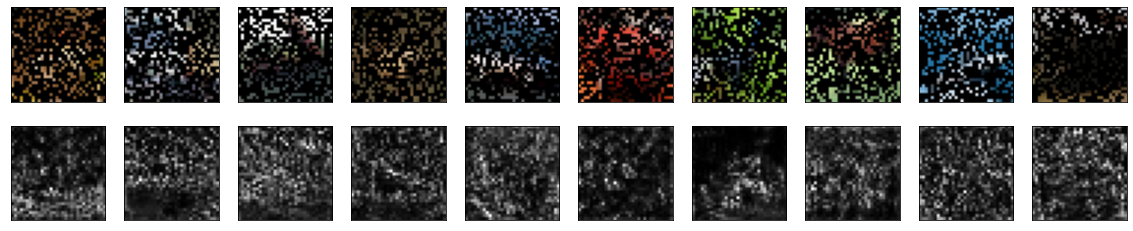

In [26]:
plt.figure(figsize=(20, 4))
for i in range(0,10):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(x_train_noise[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
for i in range(0,10):
  ax=plt.subplot(2,10,i+11)
  plt.imshow(layer_output[i,:,:,1],cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)